<a href="https://colab.research.google.com/github/Elcejas77/Aprendizaje-de-Maquina/blob/main/PARCIAL2_TAM_Arboleda_Diego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Punto2

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

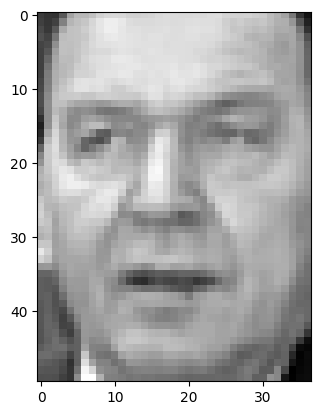

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


In [4]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import joblib

# Crear listas de steps (pipelines)
steps = [
    [('nor', MinMaxScaler()), ('cla', LogisticRegression())],  # Pipeline1
    [('nor', MinMaxScaler()), ('cla', SGDClassifier())],       # Pipeline2
    [('nor', MinMaxScaler()), ('cla', SVC())],                # Pipeline3
    [('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())],  # Pipeline4
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],        # Pipeline5
    [('nor', MinMaxScaler()), ('cla', GaussianNB())],                  # Pipeline6
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier())],      # Pipeline7
    [('nor', MinMaxScaler()), ('cla', GaussianProcessClassifier())]    # Pipeline8
]

# Definir hiperparámetros para cada clasificador
parameters = [
    {'cla__C': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]},  # Pipeline1 - Logistic Regression
    {'cla__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]},  # Pipeline2 - SGD
    {'cla__C': [1, 10, 1e2, 1e3, 1e4], 'cla__gamma': [1e-3, 1e-2, 1e-1, 1, 10]},  # Pipeline3 - SVC
    {'cla__solver': ['svd', 'lsqr', 'eigen'], 'cla__shrinkage': [None, 'auto', 0.1, 0.5, 1.0]},  # Pipeline4 - LDA
    {'cla__n_neighbors': [3, 5, 7, 9], 'cla__weights': ['uniform', 'distance']},  # Pipeline5 - KNN
    {},  # Pipeline6 - GaussianNB (no hiperparámetros)
    {'cla__n_estimators': [10, 50, 100, 200], 'cla__max_depth': [None, 10, 20, 30]},  # Pipeline7 - Random Forest
    {'cla__optimizer': ['fmin_l_bfgs_b'], 'cla__max_iter_predict': [50, 100, 200]}  # Pipeline8 - Gaussian Process
]

# Etiquetas para los modelos
label_models = [
    'MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_LDA',
    'MinMax_KNN', 'MinMax_NaiveBayes', 'MinMax_RandomForest', 'MinMax_GaussianProcess'
]

# Lista para guardar modelos entrenados
models = []
filename = 'results/lfw_models'

# Entrenar y guardar modelos
for i in range(len(steps)):
    print('Modelo %d/%d: %s' % (i + 1, len(steps), label_models[i]))
    grid_search = GridSearchCV(
        Pipeline(steps[i]), parameters[i], n_jobs=-1, cv=5,
        scoring='accuracy', refit=True, verbose=10
    )
    grid_search.fit(Xtrain, ytrain)
    models.append(grid_search)
    joblib.dump(models, filename + ".pkl")


Modelo 1/8: MinMax_Logistic
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Modelo 2/8: MinMax_SGD
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Modelo 3/8: MinMax_SVCrbf
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Modelo 4/8: MinMax_LDA
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Modelo 5/8: MinMax_KNN
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Modelo 6/8: MinMax_NaiveBayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Modelo 7/8: MinMax_RandomForest
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Modelo 8/8: MinMax_GaussianProcess
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [7]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[2].cv_results_['mean_test_score'][i]


0.4361878453038674

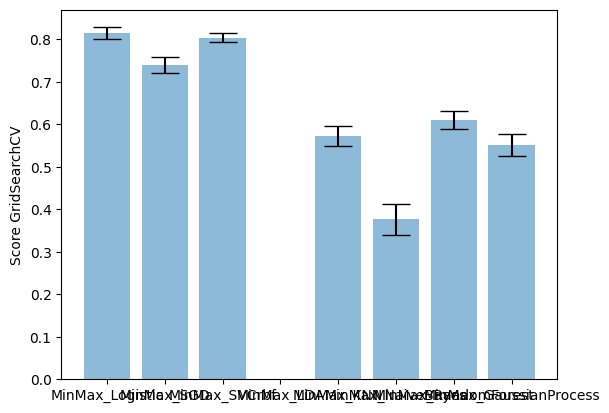

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_LDA', 'MinMax_KNN', 'MinMax_NaiveBayes', 'MinMax_RandomForest', 'MinMax_GaussianProcess']
[[0.815 0.739 0.804   nan 0.573 0.376 0.61  0.552]
 [0.014 0.018 0.011   nan 0.024 0.036 0.021 0.026]]


In [8]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

Evaluando modelo MinMax_Logistic (1/8)


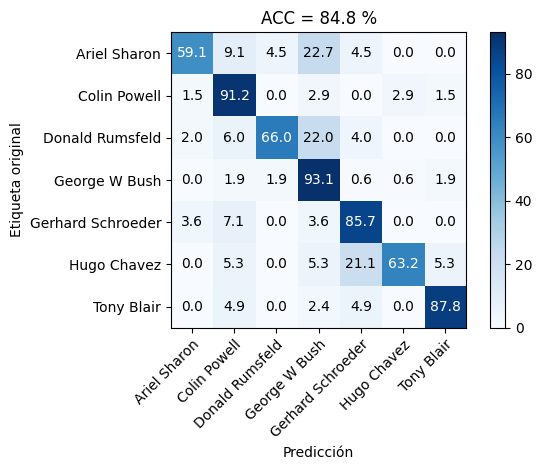

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/8)


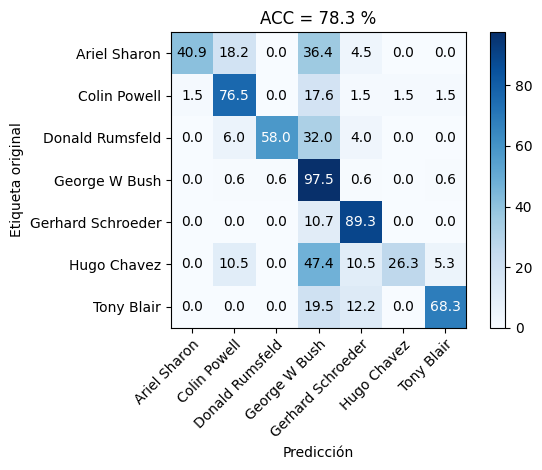

                   precision    recall  f1-score   support

     Ariel Sharon       0.90      0.41      0.56        22
     Colin Powell       0.84      0.76      0.80        68
  Donald Rumsfeld       0.97      0.58      0.72        50
    George W Bush       0.73      0.97      0.84       159
Gerhard Schroeder       0.68      0.89      0.77        28
      Hugo Chavez       0.83      0.26      0.40        19
       Tony Blair       0.90      0.68      0.78        41

         accuracy                           0.78       387
        macro avg       0.84      0.65      0.70       387
     weighted avg       0.81      0.78      0.77       387

Evaluando modelo MinMax_SVCrbf (3/8)


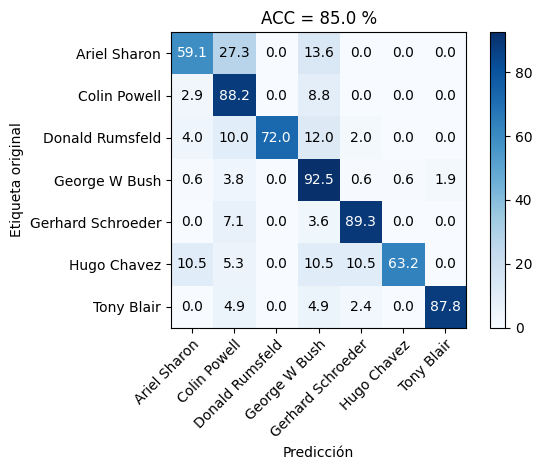

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387

Evaluando modelo MinMax_LDA (4/8)


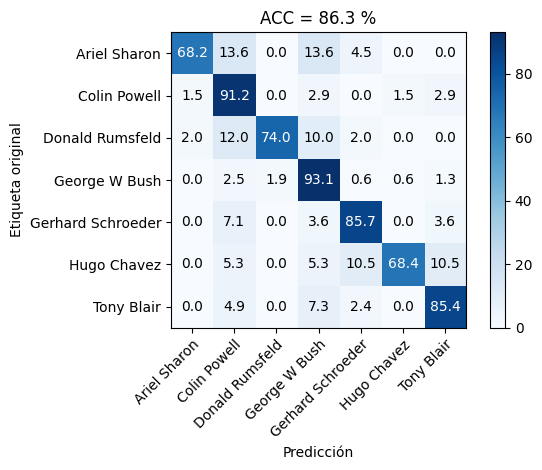

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.68      0.77        22
     Colin Powell       0.78      0.91      0.84        68
  Donald Rumsfeld       0.93      0.74      0.82        50
    George W Bush       0.91      0.93      0.92       159
Gerhard Schroeder       0.80      0.86      0.83        28
      Hugo Chavez       0.87      0.68      0.76        19
       Tony Blair       0.83      0.85      0.84        41

         accuracy                           0.86       387
        macro avg       0.86      0.81      0.83       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo MinMax_KNN (5/8)


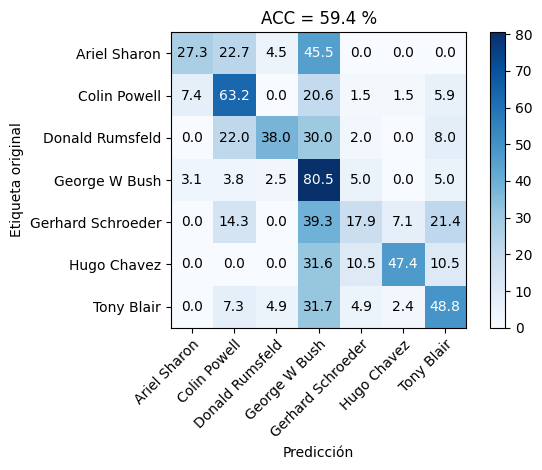

                   precision    recall  f1-score   support

     Ariel Sharon       0.38      0.27      0.32        22
     Colin Powell       0.60      0.63      0.61        68
  Donald Rumsfeld       0.73      0.38      0.50        50
    George W Bush       0.65      0.81      0.72       159
Gerhard Schroeder       0.26      0.18      0.21        28
      Hugo Chavez       0.69      0.47      0.56        19
       Tony Blair       0.45      0.49      0.47        41

         accuracy                           0.59       387
        macro avg       0.54      0.46      0.49       387
     weighted avg       0.59      0.59      0.58       387

Evaluando modelo MinMax_NaiveBayes (6/8)


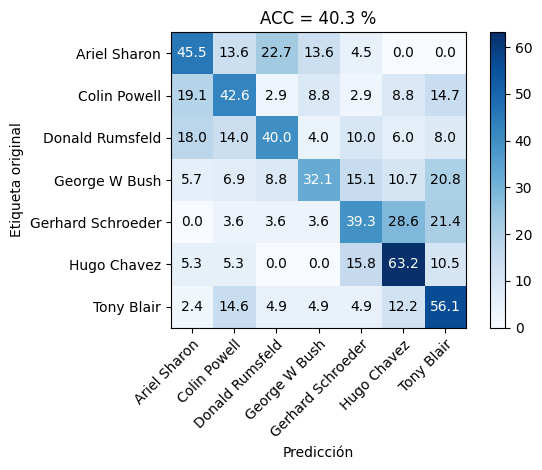

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo MinMax_RandomForest (7/8)


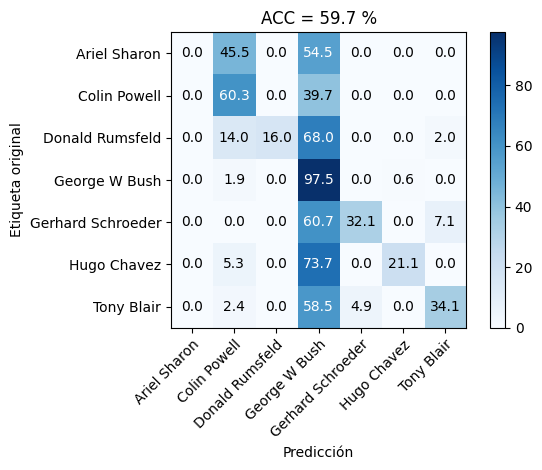

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.65      0.60      0.63        68
  Donald Rumsfeld       1.00      0.16      0.28        50
    George W Bush       0.55      0.97      0.70       159
Gerhard Schroeder       0.82      0.32      0.46        28
      Hugo Chavez       0.80      0.21      0.33        19
       Tony Blair       0.82      0.34      0.48        41

         accuracy                           0.60       387
        macro avg       0.66      0.37      0.41       387
     weighted avg       0.65      0.60      0.53       387

Evaluando modelo MinMax_GaussianProcess (8/8)


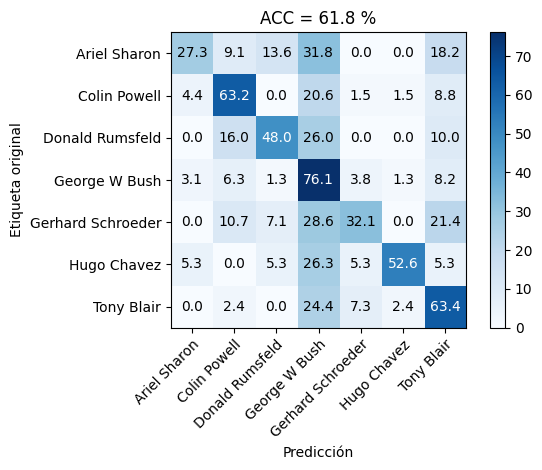

                   precision    recall  f1-score   support

     Ariel Sharon       0.40      0.27      0.32        22
     Colin Powell       0.64      0.63      0.64        68
  Donald Rumsfeld       0.75      0.48      0.59        50
    George W Bush       0.68      0.76      0.72       159
Gerhard Schroeder       0.45      0.32      0.38        28
      Hugo Chavez       0.71      0.53      0.61        19
       Tony Blair       0.43      0.63      0.51        41

         accuracy                           0.62       387
        macro avg       0.58      0.52      0.54       387
     weighted avg       0.62      0.62      0.61       387



In [9]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


Evaluando modelo MinMax_Logistic (1/8)


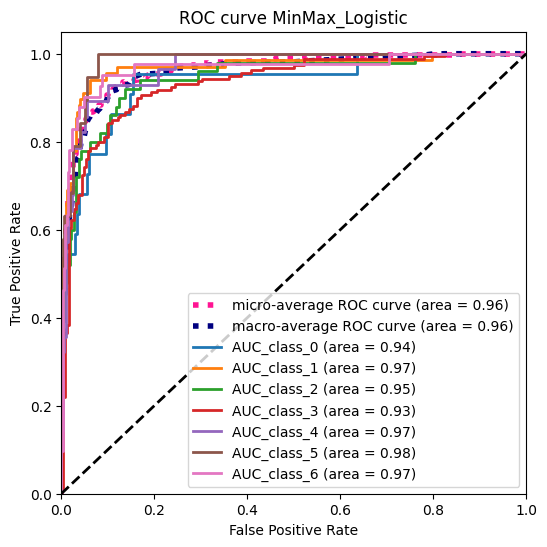

Evaluando modelo MinMax_SGD (2/8)


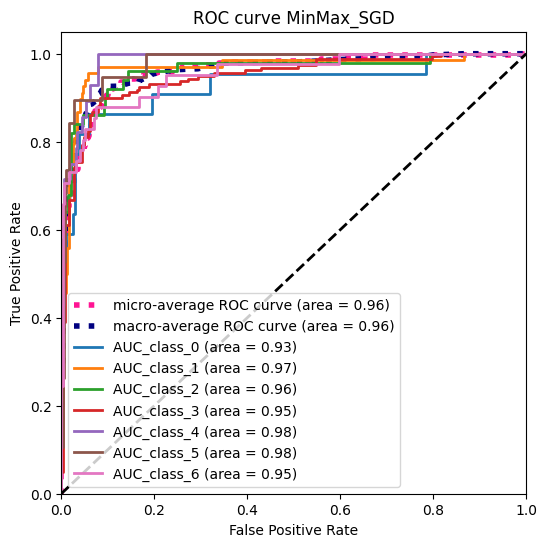

Evaluando modelo MinMax_SVCrbf (3/8)


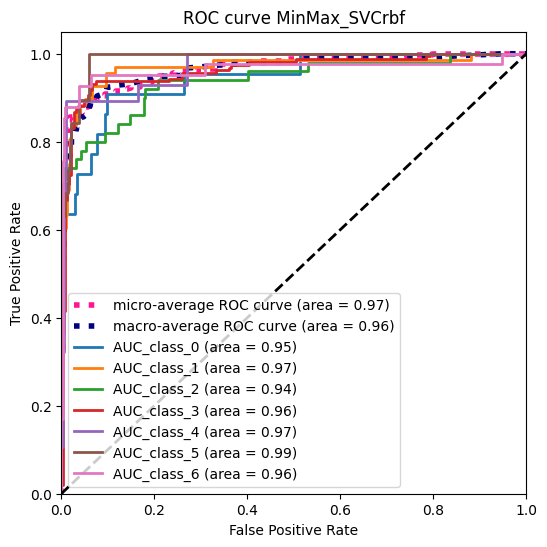

Evaluando modelo MinMax_LDA (4/8)


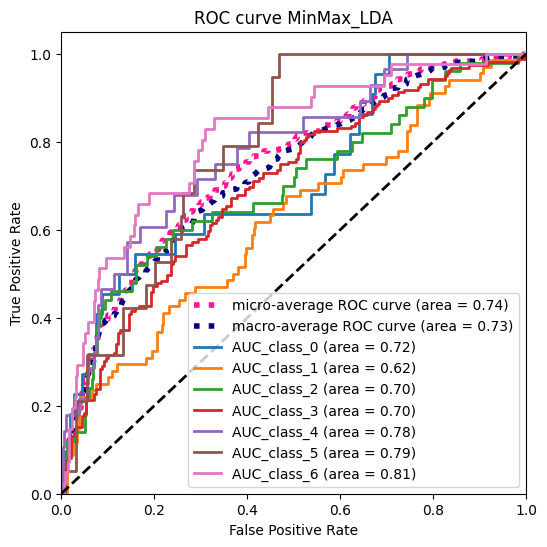

Evaluando modelo MinMax_KNN (5/8)


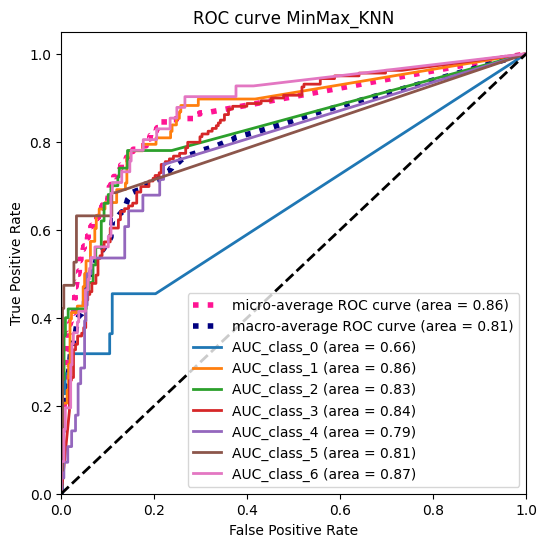

Evaluando modelo MinMax_NaiveBayes (6/8)


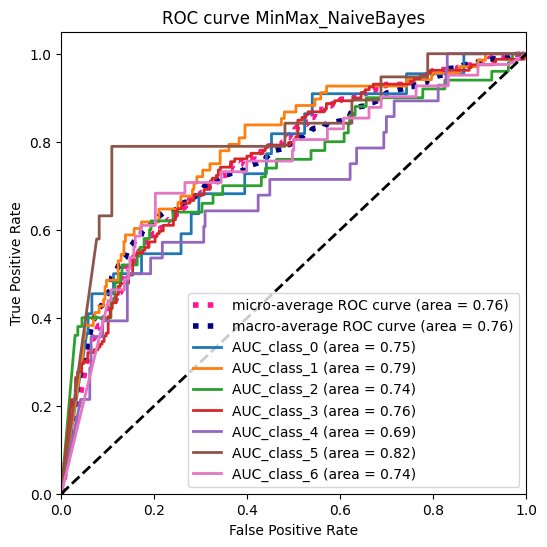

Evaluando modelo MinMax_RandomForest (7/8)


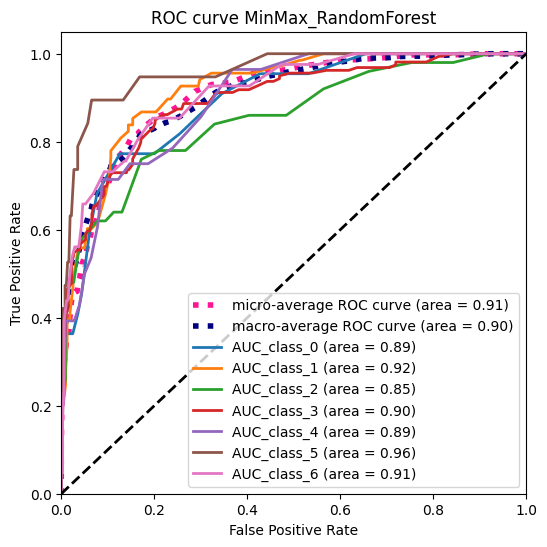

Evaluando modelo MinMax_GaussianProcess (8/8)


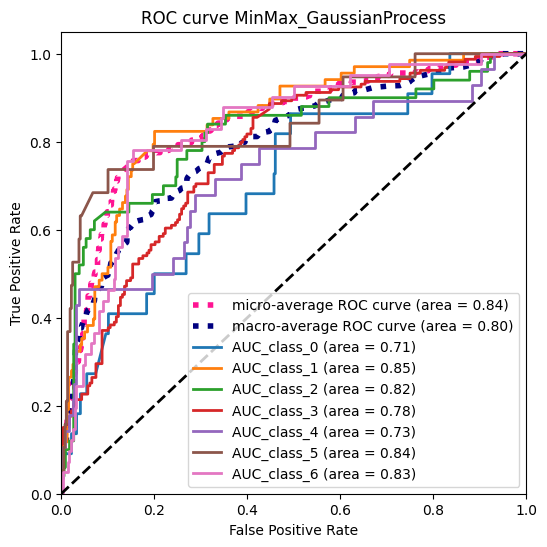

In [11]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad

    # Use predict_proba for models that do not have decision_function like KNeighborsClassifier
    try:
        ytest_score = my_model_loaded[i].decision_function(Xtest)
    except AttributeError:
        ytest_score = my_model_loaded[i].predict_proba(Xtest)

    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)